In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import datetime
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
reviews = pd.read_csv('train.tsv', sep = '\t')
reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
reviews.duplicated().sum()  # no duplicates

0

In [4]:
reviews = reviews.drop(['PhraseId','SentenceId'], axis=1)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

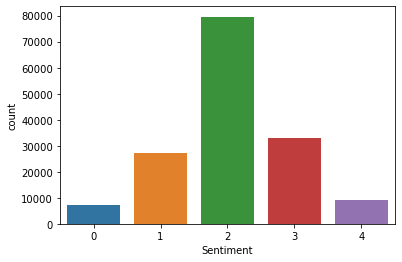

In [5]:
sns.countplot(reviews['Sentiment'])

Lets convert anything below 2 as negative(0), above 2 as positive(2) and 1 as neutral.

In [6]:
def modify_sentiment(x):
    if x < 2:
        return 0
    elif x > 2:
        return 2
    else:
        return 1

In [7]:
reviews['Sentiment'] = reviews['Sentiment'].apply(lambda x: modify_sentiment(x))

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

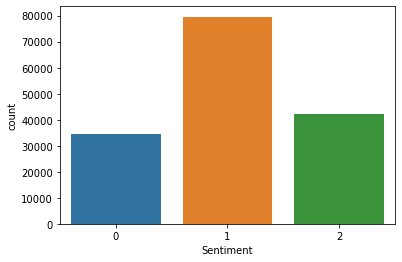

In [8]:
sns.countplot(reviews['Sentiment'])

In [9]:
def decontractions(phrase):
    '''Performs decontractions in the doc'''

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"shouldn\'t", "should not", phrase)
    phrase = re.sub(r"wouldn\'t", "would not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
        
    return phrase

In [10]:
def preprocess(text):
    
    punctuations = set(string.punctuation)
    stop_words = stopwords.words('english')
    new_text = []
    new_score = []
    for line, score in text.values:
        if len(line.split()) == 1 and line in stop_words:
            continue
        else:
            # lowercase
            line = line.lower()
            # removes punctuations
            temp = []
            for i in line:
                if i in punctuations or i.isdigit():
                    continue
                else:
                    temp.append(i)
                line = ''.join(e for e in temp)
            # removes HTML tags if any
            line = re.sub('<.*?>', ' ', line)
            # performs decontractions
            line = decontractions(line)
            # removes multiple spaces
            line = re.sub(' +', ' ', line)
            
            temp = []
            for word in line.split():
                if len(word) < 2:
                    continue
                else:
                    temp.append(word)
            line = ' '.join(e for e in temp)
            
            new_text.append(line)
            new_score.append(score)
            
    reviews = pd.DataFrame()
    reviews['Text'] = new_text
    reviews['score'] = new_score
    
    reviews = reviews[reviews.Text != '']
    reviews.to_csv('Preprocessed_Reviews.csv', index=False)
    return reviews

In [11]:
reviews = preprocess(reviews)

In [12]:
reviews.shape

(155812, 2)

In [13]:
reviews.head()

,Text,score
0,series of escapades demonstrating the adage th...,0
1,series of escapades demonstrating the adage th...,1
2,series,1
4,series,1
5,of escapades demonstrating the adage that what...,1


In [14]:
#reviews = pd.read_csv('Preprocessed.csv')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(reviews.Text, reviews.score, test_size = 0.2, random_state=101, 
                                                    stratify = reviews.score)

In [16]:
y_train.value_counts(), y_test.value_counts()

(1    63477
 2    33702
 0    27470
 Name: score, dtype: int64,
 1    15870
 2     8426
 0     6867
 Name: score, dtype: int64)

In [17]:
length_train = []
for i in X_train:
    length_train.append(len(i.split()))

<AxesSubplot:>

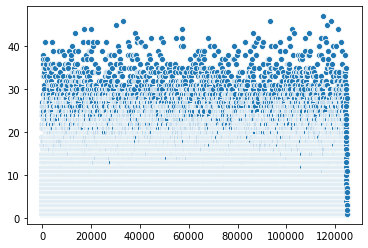

In [18]:
sns.scatterplot(range(X_train.shape[0]), length_train)

In [19]:
max_length = max(length_train) + 2 # for cls and sep tokens
max_length

49

<AxesSubplot:title={'center':'y_test'}, xlabel='score', ylabel='count'>

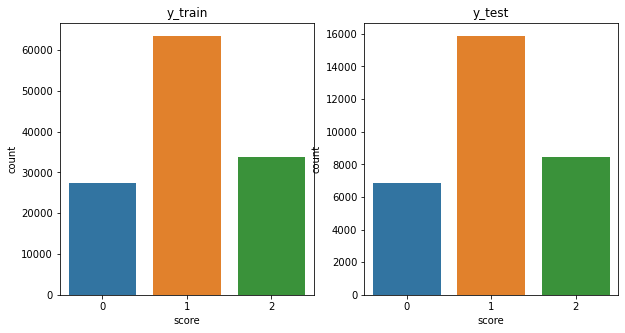

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('y_train')
sns.countplot(y_train)
plt.subplot(122)
plt.title('y_test')
sns.countplot(y_test)

The distributions are same 

In [21]:
X_train.shape, X_test.shape

((124649,), (31163,))

In [22]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
def tokenization(X, max_length):
    X_mask = np.zeros((X.shape[0], max_length))
    X_segment = np.zeros((X.shape[0], max_length))
    X_new = []
    for i in range(len(X.values)):
        temp = bert_tokenizer.encode(X.values[i], pad_to_max_length = True, max_length = max_length, truncation=True)
        X_new.append(temp)
        for j in range(max_length):
            if temp[j] != 0:
                X_mask[i][j] = 1
            else:
                continue
        
    return np.array(X_new), X_mask, X_segment

In [24]:
X_train_tok, X_train_mask, X_train_segment = tokenization(X_train, max_length)

In [25]:
X_train_tok.shape, X_train_mask.shape, X_train_segment.shape

((124649, 49), (124649, 49), (124649, 49))

In [26]:
X_test_tok, X_test_mask, X_test_segment = tokenization(X_test, max_length)

In [27]:
X_test_tok.shape, X_test_mask.shape, X_test_segment.shape

((31163, 49), (31163, 49), (31163, 49))

In [28]:
import pickle

In [29]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tok, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tok, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [30]:
# Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")

input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

INFO:absl:Using C:\Users\VYSAKH~1\AppData\Local\Temp\tfhub_modules to cache modules.


In [31]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

In [32]:
X_train_output = bert_model.predict([X_train_tok, X_train_mask, X_train_segment])
X_test_output = bert_model.predict([X_test_tok, X_test_mask, X_test_segment])

In [33]:
pickle.dump((X_train_output, X_test_output), open('Text_Features_from_BERT.pkl','wb'))

In [35]:
y_train_OHE = tf.keras.utils.to_categorical(y_train, 3)
y_test_OHE = tf.keras.utils.to_categorical(y_test, 3)

## Logistic Regression on top of retrieved features

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train_output, y_train)

LogisticRegression(n_jobs=-1)

In [53]:
lr.predict(X_test_output[9].reshape(1,-1))

array([1], dtype=int64)

In [130]:
lr_predictions = lr.predict(X_test_output)

In [152]:
roc_auc_score(y_test_OHE, lr_pred_OHE)

0.7165682255906418

Text(33.0, 0.5, 'Actual')

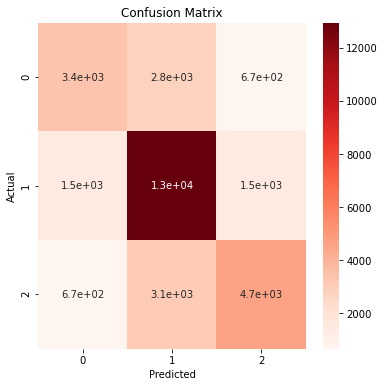

In [160]:
plt.figure(figsize=(6,6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test.values, lr_predictions), cmap='Reds', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## NN on top of retrieved features

In [119]:
class scoring(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data):
        self.validation_data = validation_data
    def on_train_begin(self, logs={}):
        self.auc=0
    def on_epoch_end(self, epoch, logs={}):
        
        predictions = self.model.predict(self.validation_data[0])
        y_val = self.validation_data[1]
     #   pred = []
        print(predictions.shape)
    #    for i in range(predictions.shape[0]):
    #       pred.append(np.argmax(predictions[i]))
        
        self.auc = roc_auc_score(y_val, predictions, multi_class='ovr')
        
        print("AUC: {}".format(self.auc))

In [125]:
input_layer = Input(shape=(768,), name='Input_layer')
dense1 = Dense(256, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(), name='Dense1')(input_layer)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(256, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(), name='Dense2')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 768)]             0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               196864    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 256)               65792     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 3)                 771       
Total params: 263,427
Trainable params: 263,427
Non-trainable params: 0
____________________________________________________

In [126]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [127]:
model.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])

In [128]:
log_dir="Tensorboard\logs_m2\\fit4\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('Weights/Model_logsm2_fit4_best.h5', verbose=1, save_best_only=True)
auc = scoring((X_test_output, y_test))

In [129]:
# dropout = 0.5, 256
model.fit(X_train_output, y_train_OHE, epochs = 10, validation_data=(X_test_output, y_test_OHE), batch_size = 32,
          callbacks=[tensorboard_callback, checkpoint, auc], verbose = 1)

Train on 124649 samples, validate on 31163 samples
Epoch 1/10
    32/124649 [..............................] - ETA: 21:10 - loss: 1.6407 - accuracy: 0.3438WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.706813). Check your callbacks.


124096/124649 [============================>.] - ETA: 0s - loss: 0.9378 - accuracy: 0.5650
Epoch 00001: val_loss improved from inf to 0.82230, saving model to Weights/Model_logsm2_fit4_best.h5
(31163, 3)
AUC: 0.7862740816514089
124649/124649 [==============================] - 22s 173us/sample - loss: 0.9373 - accuracy: 0.5652 - val_loss: 0.8223 - val_accuracy: 0.6329
Epoch 2/10
124288/124649 [============================>.] - ETA: 0s - loss: 0.8393 - accuracy: 0.6250
Epoch 00002: val_loss improved from 0.82230 to 0.77887, saving model to Weights/Model_logsm2_fit4_best.h5
(31163, 3)
AUC: 0.8125638107883462
124649/124649 [==============================] - 19s 152us/sample - loss: 0.8392 - accuracy: 0.6251 - val_loss: 0.7789 - val_accuracy: 0.6619
Epoch 3/10
124352/124649 [============================>.] - ETA: 0s - loss: 0.8146 - accuracy: 0.6409
Epoch 00003: val_loss improved from 0.77887 to 0.76567, saving model to Weights/Model_logsm2_fit4_best.h5
(31163, 3)
AUC: 0.8210110195934854
12

In [156]:
nn_pred = model.predict(X_test_output)

In [158]:
nn_pred = np.argmax(nn_pred, axis=1)

Text(33.0, 0.5, 'Actual')

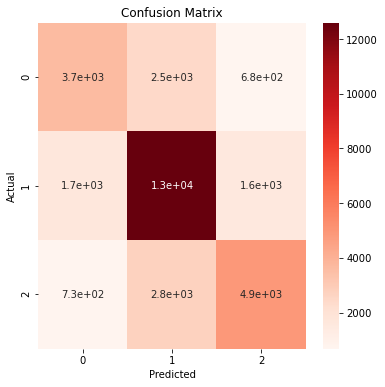

In [161]:
plt.figure(figsize=(6,6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test.values, nn_pred), cmap='Reds', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')